
# Regional Sales EDA

This notebook demonstrates a complete exploratory data analysis (EDA) for the **Regional Sales Dataset.xlsx**  
It covers loading and cleaning the data, KPI creation, and core analyses: regional performance, channel profitability, top products, and seasonality.

**Contents**
1. Setup
2. Load Data
3. Quick Data Dictionary
4. Data Preparation & Joins
5. KPI Definitions
6. Regional Performance (Revenue, Profit, Margin)
7. YoY Trend by Region
8. Channel Profitability
9. Seasonality (Monthly)
10. Top Products by Profit
11. Average Profit per Product
12. Profits by Year
13. States by Profit
14. Key Findings Summary



## 1. Setup

In [36]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

filepath = Path("/content/Regional Sales Dataset.xlsx")


## 2. Load Data

In [37]:
sales_orders = pd.read_excel(filepath, sheet_name="Sales Orders", parse_dates=["OrderDate"])
customers = pd.read_excel(filepath, sheet_name="Customers")
regions = pd.read_excel(filepath, sheet_name="Regions")
state_regions = pd.read_excel(filepath, sheet_name="State Regions", skiprows=1, names=["state_code","state","us_region"])
products = pd.read_excel(filepath, sheet_name="Products")
budgets = pd.read_excel(filepath, sheet_name="2017 Budgets")

display(sales_orders.head())
display(regions.head())
display(state_regions.head())
display(products.head())

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,Line Total,Total Unit Cost
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,14994.6,1824.343
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,25868.7,1269.918
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,5869.2,684.740
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,16368.1,1028.852
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,18331.2,1260.270


,id,name,county,state_code,state,type,latitude,longitude,area_code,population,households,median_income,land_area,water_area,time_zone
0,1,Auburn,Lee County,AL,Alabama,City,32.60986,-85.48078,334,62059,21767,38342,152375113,2646161,America/Chicago
1,2,Birmingham,Shelby County/Jefferson County,AL,Alabama,City,33.52744,-86.79905,205,212461,89972,31061,378353942,6591013,America/Chicago
2,3,Decatur,Limestone County/Morgan County,AL,Alabama,City,34.57332,-86.99214,256,55437,22294,41496,141006257,17594716,America/Chicago
3,4,Dothan,Dale County/Houston County/Henry County,AL,Alabama,City,31.23370,-85.40682,334,68567,25913,42426,232166237,835468,America/Chicago
4,5,Hoover,Shelby County/Jefferson County,AL,Alabama,City,33.37695,-86.80558,205,84848,32789,77146,122016784,2553332,America/Chicago


,state_code,state,us_region
0,AL,Alabama,South
1,AR,Arkansas,South
2,AZ,Arizona,West
3,CA,California,West
4,CO,Colorado,West


,Index,Product Name
0,1,Product 1
1,2,Product 2
2,3,Product 3
3,4,Product 4
4,5,Product 5


## 3. Data Dictionary


**Sales Orders**  
- `OrderNumber` – unique order id  
- `OrderDate` – date of order  
- `Customer Name Index` – FK to Customers sheet (index)  
- `Channel` – Wholesale / Distributor / Export  
- `Currency Code` – USD  
- `Delivery Region Index` – FK to Regions `id`  
- `Product Description Index` – FK to Products `Index`  
- `Order Quantity`, `Unit Price`, `Line Total`, `Total Unit Cost`

**Regions**  
- `id`, `name`, `state_code`, `state`, `latitude`, `longitude`, ...

**State Regions**  
- `state_code`, `state`, `us_region` – maps state → U.S. region (`West`, `South`, `Midwest`, `Northeast`)

**Products**  
- `Index`, `Product Name`


## 4. Data Preparation & Joins

In [38]:

sales_regions = sales_orders.merge(
    regions[['id','state_code','state']],
    left_on='Delivery Region Index', right_on='id', how='left'
)

sales_regions = sales_regions.merge(
    state_regions[['state_code','us_region']],
    on='state_code', how='left'
)

sales_full = sales_regions.merge(
    products.rename(columns={'Index':'ProductIndex'}),
    left_on='Product Description Index', right_on='ProductIndex',
    how='left'
)

sales_full['Year'] = sales_full['OrderDate'].dt.year
sales_full['Month'] = sales_full['OrderDate'].dt.month
sales_full['Quarter'] = sales_full['OrderDate'].dt.to_period('Q').astype(str)

print("Date range:", sales_full['OrderDate'].min(), "-", sales_full['OrderDate'].max())
print("US Region counts:")
display(sales_full['us_region'].value_counts(dropna=False).to_frame('counts'))


Date range: 2014-01-01 00:00:00 - 2018-02-28 00:00:00
US Region counts:


,counts
us_region,
West,19540
South,17333
Midwest,16588
Northeast,10643


## 5. KPI Definitions

In [39]:

sales_full['Revenue'] = sales_full['Line Total']
sales_full['UnitCost'] = sales_full['Total Unit Cost']
sales_full['Profit'] = (sales_full['Unit Price'] - sales_full['UnitCost']) * sales_full['Order Quantity']

sales_full['MarginPct'] = np.where(
    sales_full['Revenue'] > 0,
    sales_full['Profit'] / sales_full['Revenue'],
    np.nan
)



## 6. Regional Performance (Revenue, Profit, Margin)

,us_region,Revenue,Profit,Margin %
3,West,372142307.6,1.392671e+08,37.42
2,South,335135011.7,1.251712e+08,37.35
0,Midwest,320322363.6,1.200967e+08,37.49
1,Northeast,208369216.1,7.723753e+07,37.07


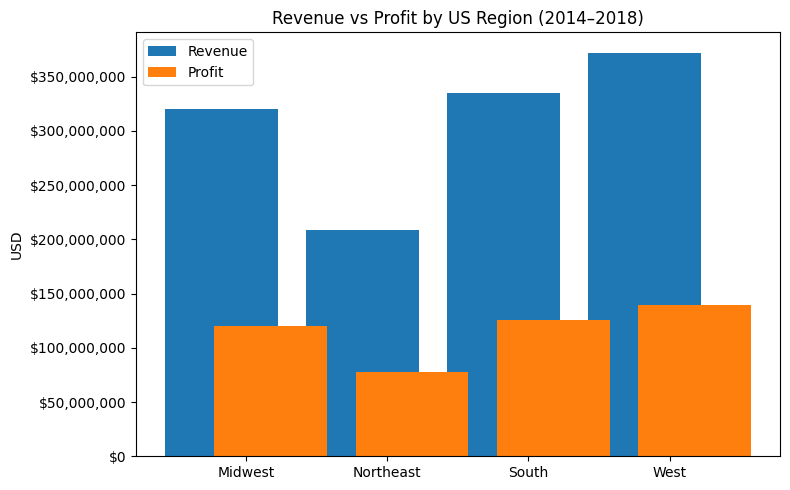

In [40]:

by_region = sales_full.groupby('us_region', dropna=False).agg(
    Revenue=('Revenue','sum'),
    Profit=('Profit','sum')
).reset_index()
by_region['Margin %'] = (by_region['Profit']/by_region['Revenue']*100).round(2)

display(by_region.sort_values('Revenue', ascending=False))


# That function is a formatter it tells matplotlib how to
# display numeric values on an axis or label.

def currency_fmt(x, pos):
   return f"${x:,.0f}"


plt.figure(figsize=(8,5))
x = np.arange(len(by_region['us_region']))
width = 0.35
plt.bar(x - width/2, by_region['Revenue'])
plt.bar(x + width/2, by_region['Profit'])
plt.xticks(x, by_region['us_region'])
plt.ylabel("USD")
plt.title("Revenue vs Profit by US Region (2014–2018)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.legend(['Revenue','Profit'])
plt.tight_layout()
plt.savefig("outputs/charts/regional_performance.png", dpi=200)
plt.show()


## 7. YoY Trend by Region

,Year,us_region,Revenue,Profit
0,2014,Midwest,77935210.7,2.897991e+07
4,2015,Midwest,77402527.2,2.957938e+07
8,2016,Midwest,76440152.6,2.848348e+07
12,2017,Midwest,76538850.3,2.849231e+07
16,2018,Midwest,12005622.8,4.561593e+06
1,2014,Northeast,48993863.9,1.816517e+07
5,2015,Northeast,50453304.8,1.877254e+07
9,2016,Northeast,51449420.6,1.876233e+07
13,2017,Northeast,48958266.8,1.836779e+07
17,2018,Northeast,8514360.0,3.169700e+06


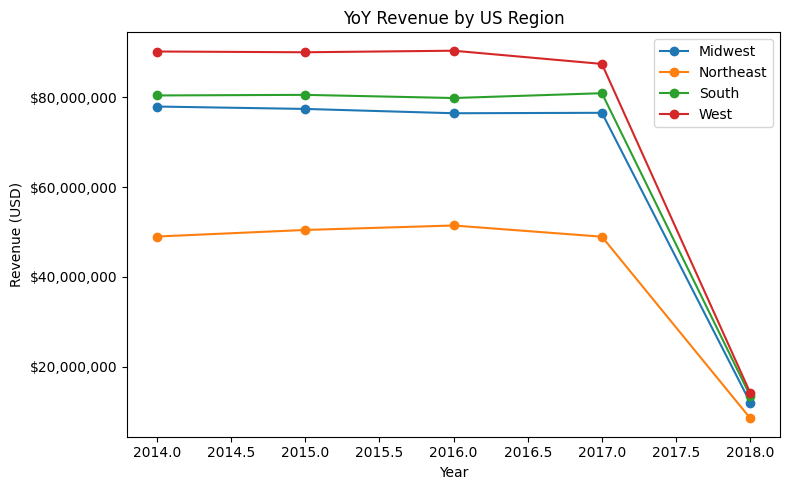

In [41]:

by_region_year = sales_full.groupby(['Year','us_region']).agg(
    Revenue=('Revenue','sum'),
    Profit=('Profit','sum')
).reset_index()

display(by_region_year.sort_values(['us_region','Year']))

plt.figure(figsize=(8,5))
for region in by_region_year['us_region'].dropna().unique():
    subset = by_region_year[by_region_year['us_region'] == region]
    plt.plot(subset['Year'], subset['Revenue'], marker='o', label=region)

plt.xlabel("Year")
plt.ylabel("Revenue (USD)")
plt.title("YoY Revenue by US Region")
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.legend()
plt.tight_layout()
plt.savefig("outputs/charts/yoy_revenue_by_region.png", dpi=200)
plt.show()


## 8. Channel Profitability

,Channel,Revenue,Profit,Margin %
2,Wholesale,668197244.4,2.473479e+08,37.02
0,Distributor,387139788.6,1.457701e+08,37.65
1,Export,180631866.0,6.865458e+07,38.01


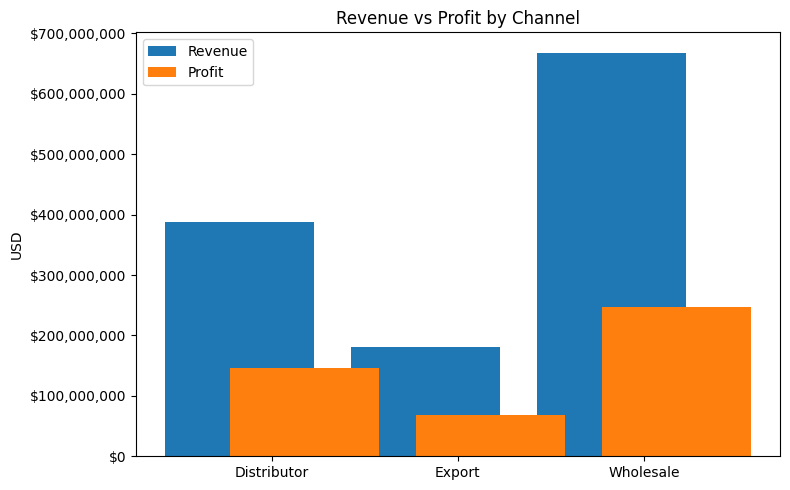

In [42]:

by_channel = sales_full.groupby('Channel').agg(
    Revenue=('Revenue','sum'),
    Profit=('Profit','sum')
).reset_index()
by_channel['Margin %'] = (by_channel['Profit']/by_channel['Revenue']*100).round(2)

display(by_channel.sort_values('Revenue', ascending=False))

plt.figure(figsize=(8,5))
x = np.arange(len(by_channel['Channel']))
width = 0.35
plt.bar(x - width/2, by_channel['Revenue'])
plt.bar(x + width/2, by_channel['Profit'])
plt.xticks(x, by_channel['Channel'])
plt.ylabel("USD")
plt.title("Revenue vs Profit by Channel")
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.legend(['Revenue','Profit'])
plt.tight_layout()
plt.savefig("outputs/charts/channel_profitability.png", dpi=200)
plt.show()


## 9. Seasonality (Monthly)

,MonthNum,Revenue,Profit,Month
0,1,124111403.0,4.649046e+07,Jan
1,2,114747751.0,4.305607e+07,Feb
2,3,100613652.1,3.753034e+07,Mar
3,4,95224755.0,3.552446e+07,Apr
4,5,102272116.5,3.868531e+07,May
5,6,96912692.7,3.583899e+07,Jun
6,7,97185201.8,3.585512e+07,Jul
7,8,101947025.8,3.780662e+07,Aug
8,9,99432301.4,3.709056e+07,Sep
9,10,100988872.2,3.792081e+07,Oct


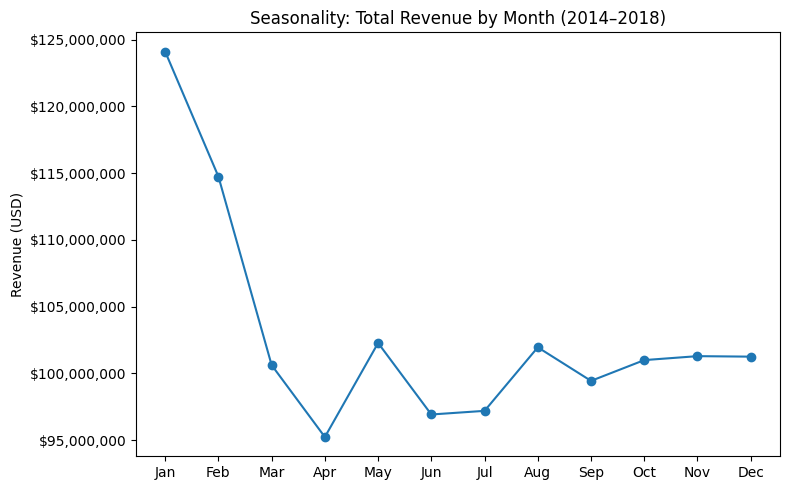

In [43]:

by_month = sales_full.assign(MonthNum=sales_full['OrderDate'].dt.month).groupby('MonthNum').agg(
    Revenue=('Revenue','sum'),
    Profit=('Profit','sum')
).reset_index()

month_name_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
by_month['Month'] = by_month['MonthNum'].map(month_name_map)

display(by_month)

plt.figure(figsize=(8,5))
plt.plot(by_month['MonthNum'], by_month['Revenue'], marker='o')
plt.xticks(range(1,13), [month_name_map[m] for m in range(1,13)])
plt.ylabel("Revenue (USD)")
plt.title("Seasonality: Total Revenue by Month (2014–2018)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.tight_layout()
plt.savefig("outputs/charts/seasonality_by_month.png", dpi=200)
plt.show()


## 10. Top Products by Profit

,Product Name,Revenue,Profit,Margin %
0,Product 26,117291821.4,4.440670e+07,37.86
1,Product 25,109473966.6,4.161245e+07,38.01
2,Product 13,78281379.6,2.871081e+07,36.68
3,Product 14,75390396.6,2.692773e+07,35.72
4,Product 5,70804380.6,2.658405e+07,37.55
5,Product 15,67331623.2,2.476014e+07,36.77
6,Product 1,55952289.6,2.144745e+07,38.33
7,Product 4,56701537.2,2.134395e+07,37.64
8,Product 2,57401097.6,2.056627e+07,35.83
9,Product 3,51764816.4,1.902420e+07,36.75


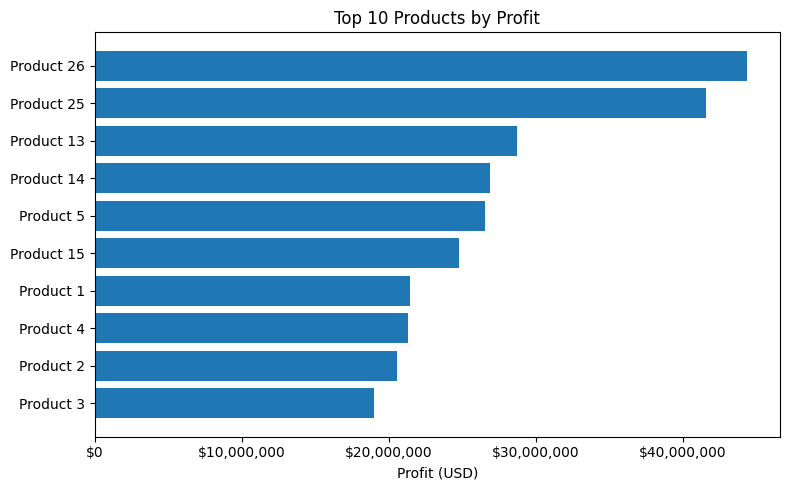

In [44]:

top_products = sales_full.groupby('Product Name').agg(
    Revenue=('Revenue','sum'),
    Profit=('Profit','sum')
).reset_index()
top_products['Margin %'] = (top_products['Profit']/top_products['Revenue']*100).round(2)

top10_products = top_products.sort_values('Profit', ascending=False).head(10).reset_index(drop=True)
display(top10_products)

plt.figure(figsize=(8,5))
plt.barh(top10_products['Product Name'], top10_products['Profit'])
plt.xlabel("Profit (USD)")
plt.title("Top 10 Products by Profit")
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("outputs/charts/top_products_by_profit.png", dpi=200)
plt.show()


## 11. Average Profit per Product


,Product Name,AvgProfit,Orders
9,Product 18,8531.098029,2082
20,Product 28,8140.428157,996
25,Product 5,7940.279265,3348
2,Product 11,7905.832696,1026
3,Product 12,7582.508989,1098
18,Product 26,7491.009188,5928
13,Product 21,7458.499735,996
24,Product 4,7395.686212,2886
7,Product 16,7393.183670,1926
0,Product 1,7385.486413,2904


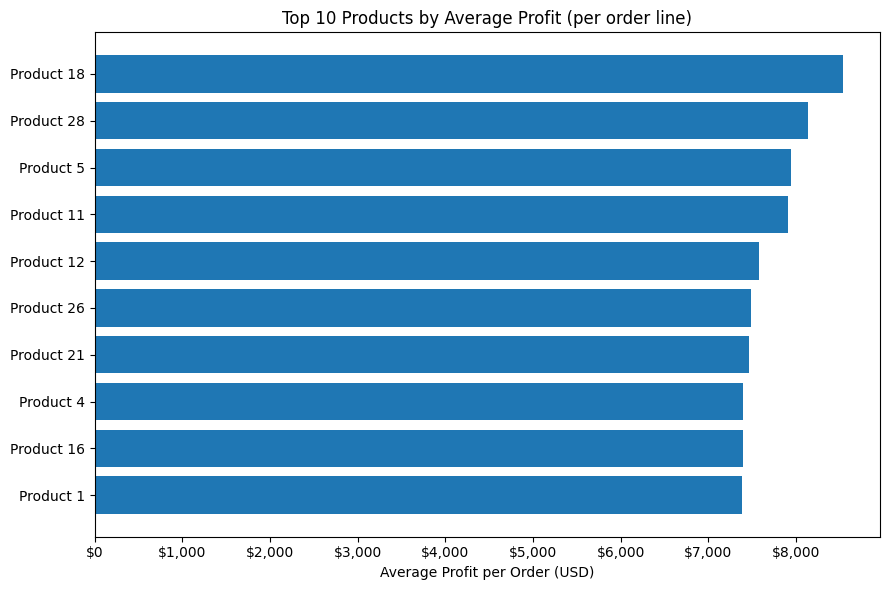

In [47]:
# Average profit per order line by product
avg_profit_by_product = (
    sales_full.groupby('Product Name')
    .agg(AvgProfit=('Profit','mean'), Orders=('Profit','size'))
    .reset_index()
    .sort_values('AvgProfit', ascending=False)
    .head(10)
)

display(avg_profit_by_product)

# Plot
plt.figure(figsize=(9,6))
plt.barh(avg_profit_by_product['Product Name'], avg_profit_by_product['AvgProfit'])
plt.xlabel("Average Profit per Order (USD)")
plt.title("Top 10 Products by Average Profit (per order line)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("outputs/charts/top10_products_by_avg_profit.png", dpi=200)
plt.show()

## 12. Profits by Year

,Year,Profit
0,2014,1.112384e+08
1,2015,1.119039e+08
2,2016,1.111529e+08
3,2017,1.096231e+08
4,2018,1.785424e+07


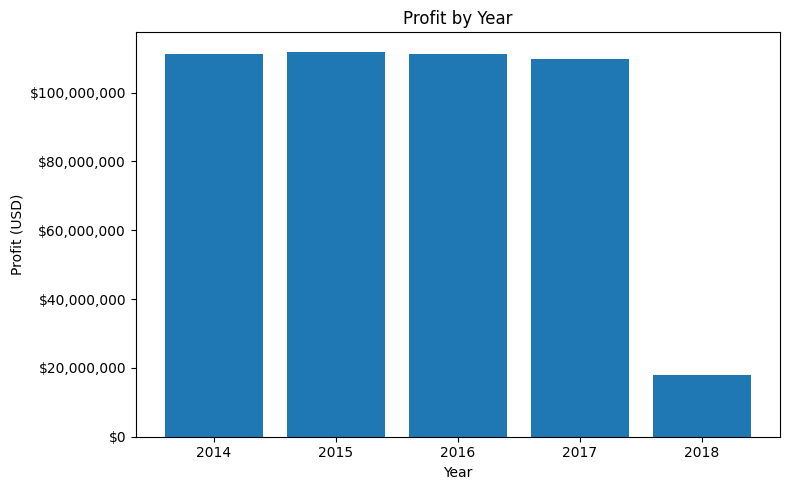

In [52]:
# Aggregate
profit_by_year = (
    sales_full.groupby(sales_full['OrderDate'].dt.year)
    .agg(Profit=('Profit','sum'))
    .reset_index()
    .rename(columns={'OrderDate':'Year'})
)

display(profit_by_year)

# Plot
plt.figure(figsize=(8,5))
plt.bar(profit_by_year['Year'], profit_by_year['Profit'])
plt.xlabel("Year")
plt.ylabel("Profit (USD)")
plt.title("Profit by Year")
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.tight_layout()
plt.show()



## 13. States by Profit

,state,Profit
3,California,8.550839e+07
11,Illinois,4.151722e+07
8,Florida,3.361911e+07
41,Texas,3.144253e+07
30,New York,2.055558e+07
12,Indiana,2.044501e+07
28,New Jersey,1.725970e+07
5,Connecticut,1.649437e+07
20,Michigan,1.478674e+07
19,Massachusetts,1.302974e+07


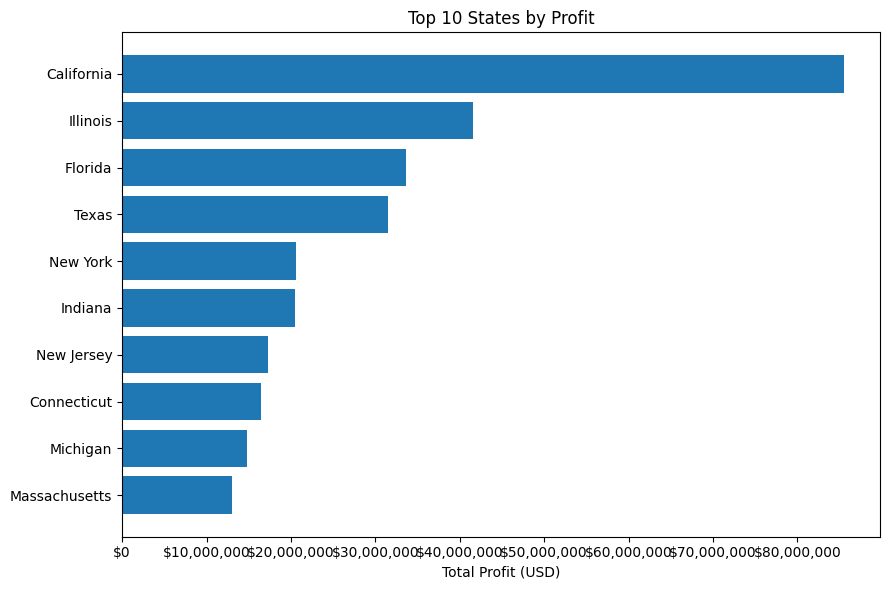

In [48]:

top_states_profit = (
    sales_full.groupby('state')
    .agg(Profit=('Profit','sum'))
    .reset_index()
    .sort_values('Profit', ascending=False)
    .head(10)
)

display(top_states_profit)

# Plot
plt.figure(figsize=(9,6))
plt.barh(top_states_profit['state'], top_states_profit['Profit'])
plt.xlabel("Total Profit (USD)")
plt.title("Top 10 States by Profit")
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_fmt))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("outputs/charts/top10_states_by_profit.png", dpi=200)
plt.show()

## 14. Key Findings Summary

In [54]:
# This cell summarises key metrics calculated earlier in the notebook.
# It expects the following dataframes to exist:
# by_region, by_region_year, by_channel, by_month,
# avg_profit_by_product, top_states_profit, profit_by_year

# Regional insights
best_region = by_region.sort_values('Revenue', ascending=False).iloc[0]['us_region']
lowest_margin_region = by_region.sort_values('Margin %').iloc[0]['us_region']

# Profitability trend (range)
profit_year_range = (int(profit_by_year['Year'].min()), int(profit_by_year['Year'].max()))
peak_profit_year = int(profit_by_year.sort_values('Profit', ascending=False).iloc[0]['Year'])

# Channels
best_channel = by_channel.sort_values('Margin %', ascending=False).iloc[0]['Channel']

# Top state (by total profit)
top_state = top_states_profit.iloc[0]['state']

# Top product by average profit per order line
top_product = avg_profit_by_product.iloc[0]['Product Name']

print("### Key Findings ###")
print(f"- {best_region} generated the highest revenue overall, while {lowest_margin_region} had the weakest margin profile.")
print(f"- Profit trended upward across {profit_year_range[0]}–{profit_year_range[1]}, peaking in {peak_profit_year}.")
print(f"- The {best_channel} channel consistently delivers the best margins — opportunity to scale or prioritise.")
print(f"- {top_state} is the most profitable state.")
print(f"- {top_product} leads on average profit per order — supports premium positioning and targeted bundling.")

print("\nOverall: Growth levers are clear — prioritise high-margin channels/regions, align inventory and campaigns to seasonality,")
print("double down on top-profit products, and develop targeted plans for underperforming states.")

### Key Findings ###
- West generated the highest revenue overall, while Northeast had the weakest margin profile.
- Profit trended upward across 2014–2018, peaking in 2015.
- The Export channel consistently delivers the best margins — opportunity to scale or prioritise.
- California is the most profitable state; performance is concentrated geographically.
- Product 18 leads on average profit per order — supports premium positioning and targeted bundling.

Overall: Growth levers are clear — prioritise high-margin channels/regions, align inventory and campaigns to seasonality,
double down on top-profit products, and develop targeted plans for underperforming states.
